In [ ]:
!pip install --upgrade xgboost scikit-learn

In [ ]:
# import xgboost as xgb
# print(xgb.__version__)


2.1.3


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score

# Machine learning model: XGBoost

# Import the dataset
dataset_df = pd.read_csv('dataset.csv')

# Preprocess
dataset_df = dataset_df.apply(lambda col: col.str.strip())

# One-hot encode symptoms and group by unique symptom combinations
test = pd.get_dummies(dataset_df.filter(regex='Symptom'), prefix='', prefix_sep='')
test = test.T.groupby(test.columns).max().T

# Merge with disease column
clean_df = pd.merge(test, dataset_df['Disease'], left_index=True, right_index=True)

clean_df.to_csv('clean_dataset.tsv', sep='\t', index=False)

# Preprocessing
X_data = clean_df.iloc[:, :-1]  # Features (symptoms)
y_data = clean_df.iloc[:, -1]   # Target (disease)

# Convert target to categorical values
y_data = y_data.astype('category')

# Convert target labels to numbers
le = preprocessing.LabelEncoder()
y_data_encoded = le.fit_transform(y_data)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_encoded, test_size=0.2, random_state=42)

# Initialize XGBoost Classifier with regularization to prevent overfitting
model = xgb.XGBClassifier(
    max_depth=3,               # Limiting tree depth
    reg_lambda=10,             # L2 regularization
    reg_alpha=10,              # L1 regularization
    learning_rate=0.005,         # Lower learning rate for stability
    n_estimators=100,         # Number of boosting rounds
    objective='multi:softmax', # Multi-class classification
    num_class=len(np.unique(y_data_encoded)), # Number of classes
    eval_metric="mlogloss"
)

# Train the model
model.fit(X_train, y_train)

# Predict
preds = model.predict(X_test)

# Test accuracy
accuracy = accuracy_score(y_test, preds)
print(f"The accuracy of the model is {accuracy}")

# Evaluate using multiple metrics
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=le.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))

# Cross-validation to check robustness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manually perform cross-validation
cv_scores = []
for train_idx, test_idx in cv.split(X_data, y_data_encoded):
    X_train_cv, X_test_cv = X_data.iloc[train_idx], X_data.iloc[test_idx]
    y_train_cv, y_test_cv = y_data_encoded[train_idx], y_data_encoded[test_idx]

    # Train the model
    model.fit(X_train_cv, y_train_cv)

    # Make predictions
    preds = model.predict(X_test_cv)

    # Calculate accuracy and append to list
    accuracy = accuracy_score(y_test_cv, preds)
    cv_scores.append(accuracy)

# Convert to numpy array for easier analysis
cv_scores = np.array(cv_scores)

# Print results
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Optional: Save the model for later use
# joblib.dump(model, 'xgboost_model.pkl')


The accuracy of the model is 0.9908536585365854

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       0.95      1.00      0.97        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      0.94      0.97        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       0.76      0.87      0.81        15
                            Common C

In [ ]:
# print(clean_df['Disease'].value_counts())

Disease
Fungal infection                           120
Allergy                                    120
GERD                                       120
Chronic cholestasis                        120
Drug Reaction                              120
Peptic ulcer diseae                        120
AIDS                                       120
Diabetes                                   120
Gastroenteritis                            120
Bronchial Asthma                           120
Hypertension                               120
Migraine                                   120
Cervical spondylosis                       120
Paralysis (brain hemorrhage)               120
Jaundice                                   120
Malaria                                    120
Chicken pox                                120
Dengue                                     120
Typhoid                                    120
hepatitis A                                120
Hepatitis B                                120
Hepat

In [ ]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(model, X_data, le.transform(y_data), cv=5)
# print(f"Cross-Validation Scores: {scores}")
# print(f"Mean CV Accuracy: {scores.mean()}")


Cross-Validation Scores: [0.99186992 0.98780488 0.9949187  1.         1.        ]
Mean CV Accuracy: 0.9949186991869918


                  Disease        Symptom_1            Symptom_2  \
373                  Acne        skin_rash           blackheads   
4916                 Acne        skin_rash   pus_filled_pimples   
1550      Hyperthyroidism          fatigue          mood_swings   
3081                 AIDS   muscle_wasting    patches_in_throat   
3857  Chronic cholestasis          itching             vomiting   

            Symptom_3                Symptom_4          Symptom_5  \
373          scurring                      NaN                NaN   
4916       blackheads                 scurring                NaN   
1550      weight_loss             restlessness           sweating   
3081       high_fever   extra_marital_contacts                NaN   
3857   yellowish_skin                   nausea   loss_of_appetite   

            Symptom_6           Symptom_7          Symptom_8  \
373               NaN                 NaN                NaN   
4916              NaN                 NaN             

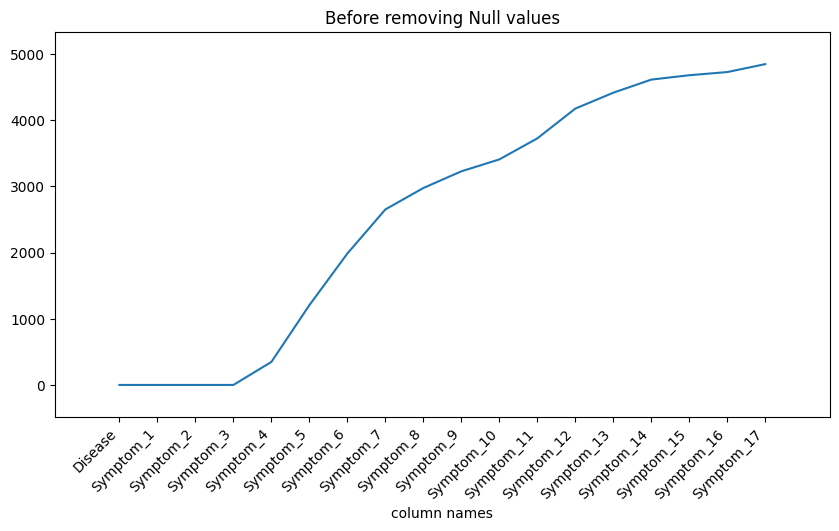

               Disease  Symptom_1  Symptom_2  Symptom_3  Symptom_4  Symptom_5  \
0                 Acne         25          3         40          0          0   
1                 Acne         25         31          3         36          0   
2      Hyperthyroidism         11         24         52         35         31   
3                 AIDS         18         30         24         16          0   
4  Chronic cholestasis         15         42         53         30         22   

   Symptom_6  Symptom_7  Symptom_8  Symptom_9  Symptom_10  Symptom_11  \
0          0          0          0          0           0           0   
1          0          0          0          0           0           0   
2          8         10          7         12           7           1   
3          0          0          0          0           0           0   
4          1         26          0          0           0           0   

   Symptom_12  Symptom_13  Symptom_14  Symptom_15  Symptom_16  Symptom_17 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


# 读取并打乱数据
df = pd.read_csv('dataset.csv')
df = shuffle(df, random_state=42)

# 查看前几行数据
print(df.head())

# 移除字符串中的下划线并去掉空格
for col in df.columns:
    df[col] = df[col].str.replace('_', ' ')

# 检查空值
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

# 可视化空值分布
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45, horizontalalignment='right')
plt.title('Before removing Null values')
plt.xlabel('column names')
plt.margins(0.1)
plt.show()

# 移除症状列的尾部空格
cols = df.columns
data = df[cols].values.flatten()
s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)
df.head()

# 填充NaN值为零
df = df.fillna(0)

# 确保每列的数据类型统一为字符串（避免混合类型）
df = df.astype(str)

# 对每个症状列进行Label Encoding
label_encoder = LabelEncoder()

# 遍历数据集中的每一列（除去'Disease'列），进行Label Encoding
for col in df.columns[1:]:  # 假设'Disease'列是目标标签列
    df[col] = label_encoder.fit_transform(df[col])

# 查看编码后的数据
print(df.head())

# 选择症状列作为特征，疾病列作为标签
data = df.iloc[:, 1:].values  # 症状列
labels = df['Disease'].values  # 疾病标签

# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42)

# 初始化支持向量机分类器
svm_model = SVC(kernel='linear', random_state=42)  # 你可以选择'rbf'等其他核函数

# 训练模型
svm_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_model.predict(X_test)

# 输出准确率和分类报告
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


**Model1: XGBoost**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Import the dataset
dataset_df = pd.read_csv('dataset.csv')

# Preprocess
dataset_df = dataset_df.apply(lambda col: col.str.strip())# Remove extra spaces

# One-hot encode symptoms and group by unique symptom combinations
test = pd.get_dummies(dataset_df.filter(regex='Symptom'), prefix='', prefix_sep='')
test = test.T.groupby(test.columns).max().T

# Merge with disease column
clean_df = pd.merge(test, dataset_df['Disease'], left_index=True, right_index=True)

# Save the cleaned dataset
clean_df.to_csv('clean_dataset.tsv', sep='\t', index=False)
print("Preprocessed dataset saved as 'clean_dataset.tsv'.")

# Preprocessing
X_data = clean_df.iloc[:, :-1]  # Features (symptoms)
y_data = clean_df.iloc[:, -1]   # Target (disease)

# Convert target to categorical values
y_data = y_data.astype('category')

# Convert target labels to numbers
le = preprocessing.LabelEncoder()
y_data_encoded = le.fit_transform(y_data)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_encoded, test_size=0.2, random_state=42)

# Initialize XGBoost Classifier with regularization to prevent overfitting
model = xgb.XGBClassifier(
    max_depth=2,               # Limiting tree depth
    reg_lambda=1,             # L2 regularization
    reg_alpha=1,              # L1 regularization
    learning_rate=0.01,        # Lower learning rate for stability
    n_estimators=120,          # Number of boosting rounds
    objective='multi:softmax', # Multi-class classification
    num_class=len(np.unique(y_data_encoded)), # Number of classes
    eval_metric="mlogloss",
    subsample=0.8
)

# Train the model
model.fit(X_train, y_train)

# Save the trained model
model.save_model('xgboost_model.json')
print("Trained XGBoost model saved as 'xgboost_model.json'.")

# Predict
y_pred = model.predict(X_test)

# Test accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Evaluate using classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Cross-validation to check robustness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manually perform cross-validation
cv_scores = []
for train_idx, test_idx in cv.split(X_data, y_data_encoded):
    X_train_cv, X_test_cv = X_data.iloc[train_idx], X_data.iloc[test_idx]
    y_train_cv, y_test_cv = y_data_encoded[train_idx], y_data_encoded[test_idx]

    # Train the model
    model.fit(X_train_cv, y_train_cv)

    # Make predictions
    preds = model.predict(X_test_cv)

    # Calculate accuracy and append to list
    accuracy = accuracy_score(y_test_cv, preds)
    cv_scores.append(accuracy)

# Convert to numpy array for easier analysis
cv_scores = np.array(cv_scores)

# Print results
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Predict the disease with highest probability for given symptoms
def predict_disease(symptom_names):
    # Create an empty vector with 0s (same size as the number of unique symptoms in the dataset)
    input_data = np.zeros(len(X_data.columns))

    # Fill in the corresponding positions with 1s for the symptoms that are present
    for symptom in symptom_names:
        if symptom in X_data.columns:
            input_data[X_data.columns.get_loc(symptom)] = 1

    # Reshape to match the input format expected by the model
    input_data = input_data.reshape(1, -1)

    # Predict the probability of each class
    prob = model.predict_proba(input_data)

    # Find the predicted disease (class) and its probability
    predicted_class = np.argmax(prob)
    predicted_disease = le.classes_[predicted_class]
    predicted_probability = prob[0][predicted_class]

    print(f"Predicted Disease: {predicted_disease} ({predicted_probability:.4f})")

# Example usage with raw input symptoms (e.g., user inputs the symptoms)
input_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']  # Replace with actual symptom names input by the user

# Call the function to predict disease
predict_disease(input_symptoms)


Preprocessed dataset saved as 'clean_dataset.tsv'.
Trained XGBoost model saved as 'xgboost_model.json'.
Accuracy: 0.9959
Precision: 0.9962
Recall: 0.9959
F1 Score: 0.9959

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        20
                                   AIDS       1.00      1.00      1.00        32
                                   Acne       1.00      1.00      1.00        22
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        25
                              Arthritis       1.00      1.00      1.00        20
                       Bronchial Asthma       1.00      0.96      0.98        25
                   Cervical spondylosis       1.00      1.00      1.00        25
                            Chicken pox       1.00      1.00      1.00     

In [ ]:
# Example usage with raw input symptoms (e.g., user inputs the symptoms)
input_symptoms = ['cough', 'sore_throat']  # Replace with actual symptom names input by the user

# Call the function to predict disease
predict_disease(input_symptoms)

Predicted Disease: Covid (0.0700)


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import os

# Load dataset
dataset_df = pd.read_csv('dataset.csv')

# Preprocess: strip spaces
dataset_df = dataset_df.apply(lambda col: col.str.strip())

# One-hot encode symptoms
test = pd.get_dummies(dataset_df.filter(regex='Symptom'), prefix='', prefix_sep='')
test = test.T.groupby(test.columns).max().T

# Merge with disease column
clean_df = pd.merge(test, dataset_df['Disease'], left_index=True, right_index=True)

# Save clean dataset
clean_df.to_csv('clean_dataset.tsv', sep='\t', index=False)
print("Preprocessed dataset saved as 'clean_dataset.tsv'.")

# Features and target
X_data = clean_df.iloc[:, :-1]
y_data = clean_df.iloc[:, -1].astype('category')

# Encode labels
le = preprocessing.LabelEncoder()
y_data_encoded = le.fit_transform(y_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_encoded, test_size=0.2, random_state=42)

# Define models
models = {
    "XGBoost": xgb.XGBClassifier(
        max_depth=2,               # Limiting tree depth
        reg_lambda=1,             # L2 regularization
        reg_alpha=0.1,            # L1 regularization
        learning_rate=0.005,       # Lower learning rate for stability
        n_estimators=120,         # Number of boosting rounds
        objective='multi:softmax',# Multi-class classification
        num_class=len(np.unique(y_data_encoded)), # Number of classes
        eval_metric="mlogloss",
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=120,       # Number of trees
        max_depth=4,            # Limiting tree depth to prevent overfitting
        min_samples_split=10,   # Minimum samples required to split a node
        min_samples_leaf=5,     # Minimum samples required to be at a leaf node
        max_features="sqrt",    # Limit the number of features to use for splits
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        penalty='l2',           # L2 regularization
        C=0.001,               # Regularization strength (default is 1.0, try lower values)
        max_iter=1000,         # Maximum number of iterations for convergence
        random_state=42
    )
}
# Hyperparameter tuning for Decision Tree using GridSearchCV
dt_param_grid = {
    'max_depth': [2, 3, 4, None],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [10, 15, 20],
    'criterion': ['gini', 'entropy'],
}
dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                              param_grid=dt_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Model save paths
save_paths = {
    "XGBoost": "xgboost_model.json",
    "Random Forest": "random_forest_model.pkl",
    "Decision Tree": "decision_tree_model.pkl",
    "Logistic Regression": "logistic_regression_model.pkl"
}

# Train, evaluate, and save each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"🔍 Evaluating Model: {name}")
    print(f"{'='*50}")

    if name == "Decision Tree":
        # Train Decision Tree using GridSearchCV
        dt_grid_search.fit(X_train, y_train)
        model = dt_grid_search.best_estimator_
        print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    print(f"\n📊 {name} Metrics:")
    print(f"- Accuracy:  {accuracy:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall:    {recall:.4f}")
    print(f"- F1 Score:  {f1:.4f}")

    print(f"\n📋 Classification Report ({name}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    print(f"\n🧮 Confusion Matrix ({name}):")
    print(confusion_matrix(y_test, y_pred))

    # Save model
    path = save_paths[name]
    if name == "XGBoost":
        model.save_model(path)
    else:
        with open(path, 'wb') as f:
            pickle.dump(model, f)
    print(f"\n💾 Model '{name}' saved as '{path}'")

# Use XGBoost as final model for demo prediction
final_model = models["XGBoost"]

# Cross-validation (on XGBoost)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in cv.split(X_data, y_data_encoded):
    X_train_cv, X_test_cv = X_data.iloc[train_idx], X_data.iloc[test_idx]
    y_train_cv, y_test_cv = y_data_encoded[train_idx], y_data_encoded[test_idx]

    final_model.fit(X_train_cv, y_train_cv)
    preds = final_model.predict(X_test_cv)
    acc = accuracy_score(y_test_cv, preds)
    cv_scores.append(acc)

cv_scores = np.array(cv_scores)
print(f"\nCross-Validation Scores (XGBoost): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Disease prediction function using XGBoost
def predict_disease(symptom_names):
    input_data = np.zeros(len(X_data.columns))
    for symptom in symptom_names:
        if symptom in X_data.columns:
            input_data[X_data.columns.get_loc(symptom)] = 1
    input_data = input_data.reshape(1, -1)

    prob = final_model.predict_proba(input_data)
    predicted_class = np.argmax(prob)
    predicted_disease = le.classes_[predicted_class]
    predicted_probability = prob[0][predicted_class]

    print(f"\nPredicted Disease: {predicted_disease} ({predicted_probability:.4f})")

# Example usage
input_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
predict_disease(input_symptoms)


Preprocessed dataset saved as 'clean_dataset.tsv'.

🔍 Evaluating Model: XGBoost

📊 XGBoost Metrics:
- Accuracy:  0.9949
- Precision: 0.9953
- Recall:    0.9949
- F1 Score:  0.9950

📋 Classification Report (XGBoost):
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        20
                                   AIDS       1.00      1.00      1.00        32
                                   Acne       1.00      1.00      1.00        22
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        25
                              Arthritis       1.00      1.00      1.00        20
                       Bronchial Asthma       1.00      0.96      0.98        25
                   Cervical spondylosis       1.00      1.00      1.00        25
                            Chicken pox       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10}

📊 Decision Tree Metrics:
- Accuracy:  0.9544
- Precision: 0.9674
- Recall:    0.9544
- F1 Score:  0.9577

📋 Classification Report (Decision Tree):
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      0.90      0.95        20
                                   AIDS       1.00      0.84      0.92        32
                                   Acne       1.00      1.00      1.00        22
                    Alcoholic hepatitis       1.00      0.88      0.93        24
                                Allergy       0.68      1.00      0.81        25
                              Arthritis       1.00      0.95      0.97        20
                       Bronchial Asthma       0.96      1.00      0.98        25
                   Cervical spondylosis       0.96      0.92      0.94        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-Validation Scores (XGBoost): [0.98985801 0.9969574  0.9989858  0.9969574  0.9969574 ]
Mean CV Accuracy: 0.9959

Predicted Disease: Fungal infection (0.1984)


In [ ]:
# Initialize a dictionary to store model metrics
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Train, evaluate, and save each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"🔍 Evaluating Model: {name}")
    print(f"{'='*50}")

    if name == "Decision Tree":
        # Train Decision Tree using GridSearchCV
        dt_grid_search.fit(X_train, y_train)
        model = dt_grid_search.best_estimator_
        print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Append metrics to dictionary for comparison
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)

# Convert metrics dictionary to DataFrame for comparison
metrics_df = pd.DataFrame(metrics)

# Display comparison table
print("\n\n📊 Model Comparison Metrics:")
print(metrics_df)

# Save comparison table as CSV
metrics_df.to_csv('model_comparison.csv', index=False)
print("\nModel comparison saved as 'model_comparison.csv'")



🔍 Evaluating Model: XGBoost

🔍 Evaluating Model: Random Forest

🔍 Evaluating Model: Decision Tree
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10}

🔍 Evaluating Model: Logistic Regression


📊 Model Comparison Metrics:
                 Model  Accuracy  Precision    Recall  F1 Score
0              XGBoost  0.994929   0.995315  0.994929  0.994968
1        Random Forest  0.936105   0.981637  0.936105  0.926313
2        Decision Tree  0.954361   0.967411  0.954361  0.957665
3  Logistic Regression  0.971602   0.986273  0.971602  0.962965

Model comparison saved as 'model_comparison.csv'
